# Latent Dirichlet Allocation and Dimension Reduction for Crime Topic Analysis

## LDA Model Building: Implemented based on Gensim Documentation examples
https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py

In [489]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import seaborn as sns
from datetime import datetime
import random

In [490]:
# import topic modeling libraries
from gensim.corpora import Dictionary
from gensim.models import LdaModel

In [491]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [492]:
def visualize_model(model, corpus, dictionary):
    return pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)

In [493]:
# import merged df with tokenized first- and second-charge descriptions (from topic_modeling.ipynb)
merged_filt = pd.read_csv('merged_filt.csv')
merged_filt_new = pd.read_csv('merged_filt_NEW.csv')
merged_filt.head()

,Unnamed: 0,id,name,race,c_charge_desc,tokenized_stemmed description,two_year_recid,r_charge_desc,r_tokenized_stemmed description
0,0,1,miguel hernandez,Other,Aggravated Assault w/Firearm,"aggrav, assault, firearm",0,NaN,NaN
1,1,3,kevon dixon,African-American,Felony Battery w/Prior Convict,"feloni, batteri, prior, convict",1,Felony Battery (Dom Strang),"feloni, batteri, domest, strangul"
2,2,4,ed philo,African-American,Possession of Cocaine,"possess, cocain",1,Driving Under The Influence,"drive, influenc"
3,3,5,marcu brown,African-American,Possession of Cannabis,"possess, cannabi",0,NaN,NaN
4,4,6,bouthy pierrelouis,Other,arrest case no charge,"arrest, case, charg",0,NaN,NaN


In [494]:
# get tokenized_stemmed descs as list and put in proper format (list of lists)
def get_tokenized_descs(df, col_label):
    tokenized = df[df[col_label].isna() == False][col_label].tolist()
    tokenized = [desc.split(', ') for desc in tokenized]
    return tokenized

In [495]:
# combine tokenized decsc for first and second offense
def get_all_tokenized_descs(df):
    tokenized = get_tokenized_descs(df, 'tokenized_stemmed description')
    r_tokenized = get_tokenized_descs(df, 'r_tokenized_stemmed description')
    tokenized.extend(r_tokenized)
    return tokenized_

In [496]:
# build a dictionary with token --> frequency mappings (for reference and filter_extremes settings)
def get_token_freq_dict(tokenized):
    token_freq = {}
    for d in tokenized:
        for t in d:
            if t not in token_freq:
                token_freq[t] = 1
            else:
                token_freq[t] += 1

In [497]:
def build_dict_corpus(tokenized_, filter_ext):
    # create a dictionary representation of documents (charge descriptions)
    dictionary = Dictionary(tokenized_)

    if filter_ext: 
        dictionary.filter_extremes(no_below=3, no_above=0.5)

    # create a BoW representation of the documents
    corpus = [dictionary.doc2bow(desc) for desc in tokenized_]
    
    return dictionary, corpus

In [498]:
def dict_corpus_stats(dictionary, corpus):
    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents: %d' % len(corpus))

In [499]:
def train_lda(random_state, dictionary, corpus):
    # set training parameters 
    num_topics = 5
    chunksize = 10000
    passes = 20
    iterations = 400
    eval_every = 1

    temp = dictionary[0]
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every,
        random_state=random_state
    )
    return model

In [500]:
# call when want to clear list of trained models
def empty_model_list(trained_models=None, clear=False):
    if clear: trained_models = []
    return trained_models

In [501]:
def train_multiple_models(trained_models, num_train):

    start = datetime.now()

    current_time = start.strftime("%H:%M:%S")
    print("START TIME =", current_time)

    offset = len(trained_models)
    for i in range(num_train):
        print('training model ' + str(i + offset) + '...')
        m = train_lda(i + offset, dictionary, corpus)
        trained_models.append(m)
    print('done.')

    end = datetime.now()

    current_time = end.strftime("%H:%M:%S")
    print("END TIME =", current_time)

    print('new models trained:', num_train)
    print('total models trained:', len(trained_models))
    return trained_models

In [502]:
def get_model_info(trained_models, random_seed):
    n = random_seed
    model = trained_models[n]
    pprint(model.print_topics())
    return visualize_model(model, corpus, dictionary)

In [701]:
# using original merged_filt
tokenized_TEST = get_all_tokenized_descs(merged_filt)
dictionary_TEST, corpus_TEST = build_dict_corpus(tokenized_TEST, filter_ext=True)
dict_corpus_stats(dictionary_TEST, corpus_TEST)
model_f = train_lda(49, dictionary_TEST, corpus_TEST)
pprint(model_f.print_topics())
visualize_model(model_f, corpus_TEST, dictionary_TEST)

Number of unique tokens: 315
Number of documents: 10598
[(0,
  '0.179*"batteri" + 0.147*"drive" + 0.130*"licens" + 0.105*"suspend" + '
  '0.057*"violenc" + 0.038*"domest" + 0.037*"burglari" + 0.034*"revok" + '
  '0.029*"feloni" + 0.025*"injunct"'),
 (1,
  '0.087*"possess" + 0.079*"cannabi" + 0.071*"gram" + 0.070*"oper" + '
  '0.068*"less" + 0.068*"licens" + 0.057*"violenc" + 0.057*"resist" + '
  '0.054*"valid" + 0.050*"obstruct"'),
 (2,
  '0.164*"possess" + 0.093*"cocain" + 0.076*"charg" + 0.076*"arrest" + '
  '0.076*"case" + 0.069*"offens" + 0.068*"suspend" + 0.049*"driver" + '
  '0.049*"licens" + 0.027*"deliveri"'),
 (3,
  '0.262*"theft" + 0.138*"grand" + 0.120*"petit" + 0.116*"degre" + '
  '0.043*"vehicl" + 0.028*"feloni" + 0.027*"motor" + 0.025*"failur" + '
  '0.018*"crimin" + 0.018*"mischief"'),
 (4,
  '0.116*"aggrav" + 0.075*"weapon" + 0.065*"batteri" + 0.054*"assault" + '
  '0.047*"dead" + 0.040*"tamper" + 0.039*"properti" + 0.038*"vehicl" + '
  '0.031*"evid" + 0.031*"physic"')]

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.096543 -0.165752       1        1  24.442129
1      0.232816  0.108790       2        1  19.401151
2      0.233725  0.052302       3        1  27.436096
3     -0.317828  0.281198       4        1  15.973132
4     -0.245255 -0.276538       5        1  12.747491, topic_info=       Term         Freq        Total Category  logprob  loglift
25    theft  1239.000000  1239.000000  Default  30.0000  30.0000
3   batteri  1538.000000  1538.000000  Default  29.0000  29.0000
20    drive  1063.000000  1063.000000  Default  28.0000  28.0000
8   possess  1832.000000  1832.000000  Default  27.0000  27.0000
24    grand   651.000000   651.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
73   vehicl   144.959595   348.124109   Topic5  -3.2587   1.1837
3   batteri   245.565705  1538.464039   Topic5  -2.7316   0.2249
37   person    32.238484    58.701715   Topic5  -4.7620   1.4605
58     fals    43.898542   170.199541   Topic5  -4.4532   0.7047
2   firearm    35.188520    93.679088   Topic5  -4.6744   1.0807

[225 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
121       5  0.988177       accid
228       3  0.973073         act
0         5  0.998771      aggrav
212       5  0.969302     alcohol
91        3  0.986671  alprazolam
...     ...       ...         ...
65        2  0.443943     violenc
292       2  0.976941        warn
55        5  0.996869      weapon
161       1  0.983114         wit
180       1  0.953302        year

[206 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [467]:
# using new merged_filt
tokenized = get_all_tokenized_descs(merged_filt_new)
dictionary, corpus = build_dict_corpus(tokenized, filter_ext=True)
dict_corpus_stats(dictionary, corpus)
#trained_models_fn = empty_model_list(trained_models=None,clear=True)
print('# trained models:', len(trained_models_fn))
num_train = 50
trained_models_fn = train_multiple_models(trained_models_fn, num_train)

Number of unique tokens: 315
Number of documents: 10598
# trained models: 0
START TIME = 19:26:02
training model 0...
training model 1...
training model 2...
training model 3...
training model 4...
training model 5...
training model 6...
training model 7...
training model 8...
training model 9...
training model 10...
training model 11...
training model 12...
training model 13...
training model 14...
training model 15...
training model 16...
training model 17...
training model 18...
training model 19...
training model 20...
training model 21...
training model 22...
training model 23...
training model 24...
training model 25...
training model 26...
training model 27...
training model 28...
training model 29...
training model 30...
training model 31...
training model 32...
training model 33...
training model 34...
training model 35...
training model 36...
training model 37...
training model 38...
training model 39...
training model 40...
training model 41...
training model 42...
training 

In [729]:
vis = get_model_info(trained_models_fn, 3)
vis

[(0,
  '0.190*"licens" + 0.124*"suspend" + 0.107*"drive" + 0.063*"oper" + '
  '0.051*"violenc" + 0.051*"resist" + 0.049*"valid" + 0.048*"offens" + '
  '0.045*"obstruct" + 0.034*"driver"'),
 (1,
  '0.263*"possess" + 0.104*"cannabi" + 0.088*"cocain" + 0.088*"gram" + '
  '0.084*"less" + 0.042*"structur" + 0.039*"trespass" + 0.035*"convey" + '
  '0.028*"deliveri" + 0.019*"paraphernalia"'),
 (2,
  '0.124*"violenc" + 0.084*"domest" + 0.060*"feloni" + 0.055*"injunct" + '
  '0.053*"batteri" + 0.039*"tamper" + 0.031*"physic" + 0.031*"evid" + '
  '0.028*"strangul" + 0.021*"harm"'),
 (3,
  '0.167*"grand" + 0.154*"theft" + 0.140*"degre" + 0.074*"burglari" + '
  '0.049*"unoccupi" + 0.043*"dwell" + 0.022*"crimin" + 0.022*"mischief" + '
  '0.020*"convey" + 0.018*"disord"'),
 (4,
  '0.202*"batteri" + 0.090*"theft" + 0.080*"petit" + 0.079*"arrest" + '
  '0.079*"charg" + 0.079*"case" + 0.056*"aggrav" + 0.047*"vehicl" + '
  '0.027*"assault" + 0.024*"weapon"')]


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.267278  0.270193       1        1  23.107112
1      0.317069  0.228820       2        1  21.546197
2     -0.205673 -0.075990       3        1  11.583995
3      0.196730 -0.139927       4        1  14.133723
4     -0.040847 -0.283097       5        1  29.628973, topic_info=         Term         Freq        Total Category  logprob  loglift
8     possess  1679.000000  1679.000000  Default  30.0000  30.0000
21     licens  1297.000000  1297.000000  Default  29.0000  29.0000
3     batteri  1955.000000  1955.000000  Default  28.0000  28.0000
25      theft  1434.000000  1434.000000  Default  27.0000  27.0000
24      grand   698.000000   698.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
5      feloni   177.718256   382.541762   Topic5  -3.8983   0.4498
122    attend    33.648980    45.641646   Topic5  -5.5626   0.9116
30      offic    52.137104    98.817727   Topic5  -5.1247   0.5770
134     damag    53.979495   111.426333   Topic5  -5.0899   0.4917
96   properti    56.029215   129.790383   Topic5  -5.0527   0.3764

[218 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
121       5  0.992454   accid
228       5  0.969030     act
0         1  0.008073  aggrav
0         5  0.990959  aggrav
267       5  0.933920     aid
...     ...       ...     ...
292       4  0.994759    warn
55        1  0.223416  weapon
55        5  0.774510  weapon
161       3  0.982336     wit
180       5  0.983861    year

[196 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [721]:
# using new merged_filt -- DONT FILTER EXTREMES -- APRIL 11
tokenized2 = get_all_tokenized_descs(merged_filt_new)
dictionary2, corpus2 = build_dict_corpus(tokenized, filter_ext=False)
dict_corpus_stats(dictionary2, corpus2)
trained_models_fn2 = empty_model_list(trained_models=None,clear=True)
print('# trained models:', len(trained_models_fn2))
num_train = 25
trained_models_fn2 = train_multiple_models(trained_models_fn2, num_train)

Number of unique tokens: 517
Number of documents: 10598
# trained models: 0
START TIME = 23:15:06
training model 0...
training model 1...
training model 2...
training model 3...
training model 4...
training model 5...
training model 6...
training model 7...
training model 8...
training model 9...
training model 10...
training model 11...
training model 12...
training model 13...
training model 14...
training model 15...
training model 16...
training model 17...
training model 18...
training model 19...
training model 20...
training model 21...
training model 22...
training model 23...
training model 24...
done.
END TIME = 23:39:37
new models trained: 25
total models trained: 25


In [728]:
vis2 = get_model_info(trained_models_fn2, 4)
vis2

[(0,
  '0.095*"licens" + 0.095*"offens" + 0.095*"suspend" + 0.068*"driver" + '
  '0.050*"aggrav" + 0.049*"weapon" + 0.034*"tag" + 0.031*"dead" + '
  '0.029*"assault" + 0.028*"oper"'),
 (1,
  '0.113*"charg" + 0.113*"arrest" + 0.113*"case" + 0.105*"valid" + '
  '0.105*"oper" + 0.102*"licens" + 0.049*"possess" + 0.046*"vehicl" + '
  '0.030*"paraphernalia" + 0.030*"drug"'),
 (2,
  '0.168*"possess" + 0.113*"violenc" + 0.093*"cannabi" + 0.078*"cocain" + '
  '0.078*"gram" + 0.074*"less" + 0.062*"resist" + 0.055*"obstruct" + '
  '0.025*"deliveri" + 0.023*"domest"'),
 (3,
  '0.310*"batteri" + 0.069*"burglari" + 0.063*"possess" + 0.037*"unoccupi" + '
  '0.032*"dwell" + 0.029*"use" + 0.023*"fals" + 0.017*"unlaw" + 0.017*"convey" '
  '+ 0.016*"name"'),
 (4,
  '0.142*"theft" + 0.132*"drive" + 0.117*"licens" + 0.094*"suspend" + '
  '0.075*"grand" + 0.065*"petit" + 0.063*"degre" + 0.043*"trespass" + '
  '0.041*"feloni" + 0.033*"structur"')]


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.235130 -0.044990       1        1  14.669631
1      0.038924  0.097749       2        1  18.632295
2     -0.333857  0.224276       3        1  23.315622
3     -0.188242 -0.344652       4        1  19.329651
4      0.248044  0.067617       5        1  24.052800, topic_info=         Term         Freq        Total Category  logprob  loglift
3     batteri  1772.000000  1772.000000  Default  30.0000  30.0000
25      theft  1014.000000  1014.000000  Default  29.0000  29.0000
20      drive   939.000000   939.000000  Default  28.0000  28.0000
65    violenc   778.000000   778.000000  Default  27.0000  27.0000
8     possess  1792.000000  1792.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
143    occupi    47.889612   106.889550   Topic5  -5.0011   0.6220
63     domest    82.878477   239.872454   Topic5  -4.4527   0.3622
0      aggrav    86.110836   336.500084   Topic5  -4.4144   0.0620
105     stalk    22.302762    46.689968   Topic5  -5.7653   0.6861
96   properti    29.857358   109.962714   Topic5  -5.4736   0.1212

[218 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
121       1  0.535317   accid
121       4  0.456978   accid
228       1  0.935812     act
0         1  0.644874  aggrav
0         2  0.098068  aggrav
...     ...       ...     ...
292       3  0.984172    warn
55        1  0.997575  weapon
161       1  0.946908     wit
291       5  0.914854     xlr
180       1  0.936508    year

[199 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [53]:
# NOTES:

# random seed : notes
# 13: not great but ??
# 15: good topic spread, but topics less coherent 
# 17: did a good job with drug possession/selling/etc.
# 23: kind of decent! def have topic for property crimes, sort of for violent, two seem drug related, and one seems like driving/car related)
# 24: (2) property-ish, (3) driving-related, (4) drug, (5) violent/destructive
# 26: sort of good but sort of random
# 27: same as above

# filt set
# 36: decent? (1) violent/destructive (2) non-violent theft/drug delivery (3) driving (4) drug possession (5) violent/armed
# 37: decent but some topic overlap
# 39: good topic spread
# 42: ok but some weird mix of violence/drug
# 49: GOOD!!!

# trained_models_fn
# 3: decent; good topic spread
# 35...not great but idk
# 46: grouped violent stuff but others are sort of mixed idk

In [354]:
def topic_distr_to_cols(model, tokenized_docs):
    topics = [model.get_document_topics(dictionary.doc2bow(doc), minimum_probability=0) for doc in tokenized_docs]
    rows = [[topic_distr[i][1] for i in range(len(topic_distr))] for topic_distr in topics]
    columns = [[row[i] for row in rows] for i in range(len(rows[0]))] 
    return columns
    
def get_max_topics(model, tokenized_docs):
    topics = [model.get_document_topics(dictionary.doc2bow(doc), minimum_probability=0) for doc in tokenized_docs]
    rows = [[topic_distr[i][1] for i in range(len(topic_distr))] for topic_distr in topics]
    max_topics = [np.argmax(row) + 1 for row in rows]
    return max_topics

In [355]:
def get_topic_distr_df(model, desc_col, tokenized_stemmed, df):

    cols = topic_distr_to_cols(model, tokenized_stemmed)
    max_topics = get_max_topics(model, tokenized_stemmed)
    d = {
         'id': df['id'], 
         'name': df['name'], 
         'race': df['race'], 
         'charge description': df[desc_col], 
         'tokenized description': tokenized_stemmed,
         'max topic': max_topics, 
         't1': cols[0], 't2': cols[1], 't3': cols[2], 't4': cols[3], 't5': cols[4]}
    compas_df_topics = pd.DataFrame(data=d)
    return compas_df_topics

## Make dataframe with topic distributions for first charge descriptions

In [356]:
# df with first charge descs (NaN rows removed)
c_merged_filt_new = merged_filt_new[merged_filt_new['tokenized_stemmed description'].isna() == False]
# get tokenized stemmed descriptions in format needed for doc2bow
c_tokenized_stemmed = get_tokenized_descs(c_merged_filt_new, 'tokenized_stemmed description')
# get df given trained model, charge desc column to include, tokenized_stemmed tokens, and the df
c_compas_df_topics = get_topic_distr_df(trained_models_fn[3], 'c_charge_desc', c_tokenized_stemmed, c_merged_filt_new)
c_compas_df_topics 

,id,name,race,charge description,tokenized description,max topic,t1,t2,t3,t4,t5
0,1,miguel hernandez,Other,Aggravated Assault w/Firearm,"[aggrav, assault, firearm]",5,0.327365,0.023977,0.012681,0.014729,0.621248
1,3,kevon dixon,African-American,Felony Battery w/Prior Convict,"[feloni, batteri, prior, convict]",3,0.022650,0.018484,0.925910,0.011355,0.021600
2,4,ed philo,African-American,Possession of Cocaine,"[possess, cocain]",2,0.041795,0.879363,0.018040,0.020954,0.039848
3,5,marcu brown,African-American,Possession of Cannabis,"[possess, cannabi]",2,0.041795,0.879363,0.018040,0.020954,0.039848
4,6,bouthy pierrelouis,Other,arrest case no charge,"[arrest, case, charg]",5,0.029379,0.023976,0.012681,0.014729,0.919236
...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,African-American,Deliver Cannabis,"[deliveri, cannabi]",2,0.041795,0.879363,0.018040,0.020954,0.039848
7210,10997,malcolm simmons,African-American,Leaving the Scene of Accident,"[leav, scene, accid]",5,0.029379,0.023976,0.012681,0.014729,0.919235
7211,10999,winston gregory,Other,Aggravated Battery / Pregnant,"[aggrav, batteri, pregnant]",5,0.029379,0.023976,0.012681,0.014729,0.919236
7212,11000,farrah jean,African-American,Battery on Law Enforc Officer,"[batteri, law, enforc, offic]",5,0.022653,0.018485,0.009777,0.011356,0.937731


## Make dataframe with topic distributions for second charge descriptions

In [357]:
# df with second charge descs (NaN rows removed)
r_merged_filt_new = merged_filt_new[merged_filt_new['r_tokenized_stemmed description'].isna() == False]
# get tokenized stemmed descriptions in format needed for doc2bow
r_tokenized_stemmed = get_tokenized_descs(r_merged_filt_new, 'r_tokenized_stemmed description')
# get df given trained model, charge desc column to include, tokenized_stemmed tokens, and the df
r_compas_df_topics = get_topic_distr_df(trained_models_fn[3], 'r_charge_desc', r_tokenized_stemmed, r_merged_filt_new)
r_compas_df_topics

,id,name,race,charge description,tokenized description,max topic,t1,t2,t3,t4,t5
1,3,kevon dixon,African-American,Felony Battery (Dom Strang),"[feloni, batteri, domest, strangul]",3,0.022650,0.018484,0.925911,0.011355,0.021599
2,4,ed philo,African-American,Driving Under The Influence,"[drive, influenc]",1,0.464440,0.034109,0.018040,0.020954,0.462457
6,8,edward riddle,Caucasian,Poss of Firearm by Convic Felo,"[possess, firearm, convict, felon]",2,0.022654,0.934618,0.009777,0.011356,0.021595
9,13,bo bradac,Caucasian,Battery,[batteri],5,0.072388,0.059075,0.031245,0.036291,0.801000
11,15,ellyaher lanza,African-American,Driving License Suspended,"[drive, licens, suspend]",1,0.920605,0.023976,0.012681,0.014729,0.028010
...,...,...,...,...,...,...,...,...,...,...,...
7201,10985,kyle miller,African-American,Operating W/O Valid License,"[oper, valid, licens]",1,0.920605,0.023976,0.012681,0.014729,0.028010
7205,10990,christopher tun,Caucasian,Assault,[assault],5,0.072389,0.059075,0.031246,0.036291,0.801000
7206,10992,alexander vega,Caucasian,Possess Cannabis/20 Grams Or Less,"[possess, cannabi, gram, less]",2,0.022650,0.934623,0.009777,0.011355,0.021595
7207,10994,jarred payne,African-American,Possession of Cannabis,"[possess, cannabi]",2,0.041795,0.879363,0.018040,0.020954,0.039848


## Make two filtered dataframes:
1. Topic distributions for first charge descriptions in rows where there is a second charge description
2. Topic distributions for second charge descriptions in rows where there is a first charge description

In [358]:
# get common indices
common_idx = [i for i in r_compas_df_topics.index if i in c_compas_df_topics.index]

# filter
c_compas_df_topics_common = c_compas_df_topics.loc[common_idx]
r_compas_df_topics_common = r_compas_df_topics.loc[common_idx]
display(c_compas_df_topics_common)
display(r_compas_df_topics_common)

,id,name,race,charge description,tokenized description,max topic,t1,t2,t3,t4,t5
1,3,kevon dixon,African-American,Felony Battery w/Prior Convict,"[feloni, batteri, prior, convict]",3,0.022650,0.018484,0.925910,0.011355,0.021600
2,4,ed philo,African-American,Possession of Cocaine,"[possess, cocain]",2,0.041795,0.879363,0.018040,0.020954,0.039848
6,8,edward riddle,Caucasian,Possession Burglary Tools,"[possess, burglari, tool]",2,0.029379,0.915201,0.012681,0.014729,0.028010
9,13,bo bradac,Caucasian,Insurance Fraud,"[insur, fraud]",4,0.041796,0.034109,0.018041,0.866206,0.039849
11,15,ellyaher lanza,African-American,Battery,[batteri],5,0.072388,0.059075,0.031245,0.036291,0.801000
...,...,...,...,...,...,...,...,...,...,...,...
7201,10985,kyle miller,African-American,Possession of Cocaine,"[possess, cocain]",2,0.041795,0.879363,0.018040,0.020954,0.039848
7205,10990,christopher tun,Caucasian,arrest case no charge,"[arrest, case, charg]",5,0.029379,0.023976,0.012681,0.014729,0.919236
7206,10992,alexander vega,Caucasian,Grand Theft (Motor Vehicle),"[grand, theft, motor, vehicl]",5,0.022650,0.018484,0.009777,0.343562,0.605527
7207,10994,jarred payne,African-American,Possess Cannabis/20 Grams Or Less,"[possess, cannabi, gram, less]",2,0.022650,0.934623,0.009777,0.011355,0.021595


,id,name,race,charge description,tokenized description,max topic,t1,t2,t3,t4,t5
1,3,kevon dixon,African-American,Felony Battery (Dom Strang),"[feloni, batteri, domest, strangul]",3,0.022650,0.018484,0.925911,0.011355,0.021599
2,4,ed philo,African-American,Driving Under The Influence,"[drive, influenc]",1,0.464440,0.034109,0.018040,0.020954,0.462457
6,8,edward riddle,Caucasian,Poss of Firearm by Convic Felo,"[possess, firearm, convict, felon]",2,0.022654,0.934618,0.009777,0.011356,0.021595
9,13,bo bradac,Caucasian,Battery,[batteri],5,0.072388,0.059075,0.031245,0.036291,0.801000
11,15,ellyaher lanza,African-American,Driving License Suspended,"[drive, licens, suspend]",1,0.920605,0.023976,0.012681,0.014729,0.028010
...,...,...,...,...,...,...,...,...,...,...,...
7201,10985,kyle miller,African-American,Operating W/O Valid License,"[oper, valid, licens]",1,0.920605,0.023976,0.012681,0.014729,0.028010
7205,10990,christopher tun,Caucasian,Assault,[assault],5,0.072389,0.059075,0.031246,0.036291,0.801000
7206,10992,alexander vega,Caucasian,Possess Cannabis/20 Grams Or Less,"[possess, cannabi, gram, less]",2,0.022650,0.934623,0.009777,0.011355,0.021595
7207,10994,jarred payne,African-American,Possession of Cannabis,"[possess, cannabi]",2,0.041795,0.879363,0.018040,0.020954,0.039848


## Dimension reduction via Jensen-Shannon Divergence & Principal Coordinate Analysis 
### Classical Multidimensional Scaling

In [359]:
from pyLDAvis._prepare import js_PCoA

In [214]:
# get topic distribution matrix for first charge descriptions
c_dists = np.array([c_compas_df_topics['t1'], c_compas_df_topics['t2'], c_compas_df_topics['t3'], c_compas_df_topics['t4'], c_compas_df_topics['t5']]).T
print('shape of distribution matrix:', c_dists.shape)

In [199]:
# run js_PCoA to get 2D coordinates
c_pcoa = js_PCoA(c_dists)

In [202]:
# parse x- and y-values from array for plotting
c_xs = [c_pcoa[i][0].real for i in range(len(c_pcoa))]
c_ys = [c_pcoa[i][1].real for i in range(len(c_pcoa))]
# make scatter plot
plt.scatter(c_xs, c_ys)
plt.axhline(y=0, color='red')
plt.axvline(x=0, color='red')

In [213]:
# make new df with PC values added
c_d_pc = {'id': c_compas_df_topics['id'], 
     'name': c_compas_df_topics['name'],
     'race': c_compas_df_topics['race'],
     'charge description': c_compas_df_topics['charge description'], 
     'tokenized description': c_compas_df_topics['tokenized description'],
     'max topic': c_compas_df_topics['max topic'], 
     'PC1': xs,
     'PC2': ys,
     't1': c_compas_df_topics['t1'], 
     't2': c_compas_df_topics['t2'], 
     't3': c_compas_df_topics['t3'], 
     't4': c_compas_df_topics['t4'], 
     't5': c_compas_df_topics['t5']}
c_compas_df_pc = pd.DataFrame(data=c_d_pc)
c_compas_df_pc

,id,name,race,charge description,tokenized description,max topic,PC1,PC2,t1,t2,t3,t4,t5
0,1,miguel hernandez,Other,Aggravated Assault w/Firearm,"[aggrav, assault, firearm]",5,0.166879+0.000000j,-0.044915+0.000000j,0.327364,0.023977,0.012681,0.014729,0.621249
1,3,kevon dixon,African-American,Felony Battery w/Prior Convict,"[feloni, batteri, prior, convict]",3,-0.116025+0.000000j,-0.117918+0.000000j,0.022650,0.018484,0.925911,0.011355,0.021599
2,4,ed philo,African-American,Possession of Cocaine,"[possess, cocain]",2,-0.239653+0.000000j,0.213270+0.000000j,0.041795,0.879363,0.018040,0.020954,0.039848
3,5,marcu brown,African-American,Possession of Cannabis,"[possess, cannabi]",2,-0.239653+0.000000j,0.213270+0.000000j,0.041795,0.879363,0.018040,0.020954,0.039848
4,6,bouthy pierrelouis,Other,arrest case no charge,"[arrest, case, charg]",5,0.242562+0.000000j,0.049304+0.000000j,0.029379,0.023976,0.012681,0.014729,0.919236
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,African-American,Deliver Cannabis,"[deliveri, cannabi]",2,-0.239653+0.000000j,0.213270+0.000000j,0.041795,0.879363,0.018040,0.020954,0.039848
7210,10997,malcolm simmons,African-American,Leaving the Scene of Accident,"[leav, scene, accid]",5,0.242561+0.000000j,0.049304+0.000000j,0.029379,0.023976,0.012681,0.014729,0.919235
7211,10999,winston gregory,Other,Aggravated Battery / Pregnant,"[aggrav, batteri, pregnant]",5,0.242561+0.000000j,0.049304+0.000000j,0.029379,0.023976,0.012681,0.014729,0.919236
7212,11000,farrah jean,African-American,Battery on Law Enforc Officer,"[batteri, law, enforc, offic]",5,0.261749+0.000000j,0.053065+0.000000j,0.022652,0.018485,0.009777,0.011356,0.937731


In [259]:
# get topic distribution matrix for second charge descriptions
r_dists = np.array([r_compas_df_topics['t1'], r_compas_df_topics['t2'], r_compas_df_topics['t3'], r_compas_df_topics['t4'], r_compas_df_topics['t5']]).T
print('shape of distribution matrix:', r_dists.shape)

(3413, 5)

In [216]:
# run js_PCoA to get 2D coordinates
r_pcoa = js_PCoA(r_dists)

In [230]:
# parse x- and y-values from array for plotting
r_xs = [pcoa[i][0].real for i in range(len(r_pcoa))]
r_ys = [pcoa[i][1].real for i in range(len(r_pcoa))]
# make scatter plot
plt.scatter(r_xs, r_ys)
plt.axhline(y=0, color='red')
plt.axvline(x=0, color='red')

<ipython-input-230-3da83cca0b86>:1: ComplexWarning: Casting complex values to real discards the imaginary part
  xs = [float(pcoa[i][0]) for i in range(len(pcoa))]
<ipython-input-230-3da83cca0b86>:2: ComplexWarning: Casting complex values to real discards the imaginary part
  ys = [float(pcoa[i][1]) for i in range(len(pcoa))]


In [232]:
# make new df with PC values added
r_d_pc = {'id': r_compas_df_topics['id'], 
     'name': r_compas_df_topics['name'],
     'race': r_compas_df_topics['race'],
     'charge description': r_compas_df_topics['charge description'], 
     'tokenized description': r_compas_df_topics['tokenized description'],
     'max topic': r_compas_df_topics['max topic'], 
     'PC1': xs,
     'PC2': ys,
     't1': r_compas_df_topics['t1'], 
     't2': r_compas_df_topics['t2'], 
     't3': r_compas_df_topics['t3'], 
     't4': r_compas_df_topics['t4'], 
     't5': r_compas_df_topics['t5']}
r_compas_df_pc = pd.DataFrame(data=r_d_pc)
r_compas_df_pc

,id,name,race,charge description,tokenized description,max topic,PC1,PC2,t1,t2,t3,t4,t5
1,3,kevon dixon,African-American,Felony Battery (Dom Strang),"[feloni, batteri, domest, strangul]",3,0.055780,0.096747,0.022650,0.018484,0.925910,0.011355,0.021600
2,4,ed philo,African-American,Driving Under The Influence,"[drive, influenc]",1,-0.146726,0.126366,0.464440,0.034109,0.018040,0.020954,0.462457
6,8,edward riddle,Caucasian,Poss of Firearm by Convic Felo,"[possess, firearm, convict, felon]",2,0.264451,-0.225572,0.022654,0.934618,0.009777,0.011356,0.021595
9,13,bo bradac,Caucasian,Battery,[batteri],5,0.069678,0.208953,0.072388,0.059075,0.031245,0.036291,0.801000
11,15,ellyaher lanza,African-American,Driving License Suspended,"[drive, licens, suspend]",1,-0.264880,-0.075839,0.920605,0.023976,0.012681,0.014729,0.028010
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7201,10985,kyle miller,African-American,Operating W/O Valid License,"[oper, valid, licens]",1,-0.264880,-0.075839,0.920605,0.023976,0.012681,0.014729,0.028010
7205,10990,christopher tun,Caucasian,Assault,[assault],5,0.069677,0.208952,0.072389,0.059075,0.031246,0.036291,0.801000
7206,10992,alexander vega,Caucasian,Possess Cannabis/20 Grams Or Less,"[possess, cannabi, gram, less]",2,0.264459,-0.225573,0.022650,0.934623,0.009777,0.011355,0.021595
7207,10994,jarred payne,African-American,Possession of Cannabis,"[possess, cannabi]",2,0.229037,-0.188034,0.041795,0.879363,0.018040,0.020954,0.039848


## Append second offense dataframe to first offense dataframe
Add a column to distinguish first vs. second offense

In [360]:
charge_type = ['C'] * len(c_compas_df_topics_common)
charge_type.extend(['R'] * len(r_compas_df_topics_common))
len(charge_type)
cr_topics_common = c_compas_df_topics_common.append(r_compas_df_topics_common)
cr_topics_common.insert(1, 'charge type', charge_type)
cr_topics_common

,id,charge type,name,race,charge description,tokenized description,max topic,t1,t2,t3,t4,t5
1,3,C,kevon dixon,African-American,Felony Battery w/Prior Convict,"[feloni, batteri, prior, convict]",3,0.022650,0.018484,0.925910,0.011355,0.021600
2,4,C,ed philo,African-American,Possession of Cocaine,"[possess, cocain]",2,0.041795,0.879363,0.018040,0.020954,0.039848
6,8,C,edward riddle,Caucasian,Possession Burglary Tools,"[possess, burglari, tool]",2,0.029379,0.915201,0.012681,0.014729,0.028010
9,13,C,bo bradac,Caucasian,Insurance Fraud,"[insur, fraud]",4,0.041796,0.034109,0.018041,0.866206,0.039849
11,15,C,ellyaher lanza,African-American,Battery,[batteri],5,0.072388,0.059075,0.031245,0.036291,0.801000
...,...,...,...,...,...,...,...,...,...,...,...,...
7201,10985,R,kyle miller,African-American,Operating W/O Valid License,"[oper, valid, licens]",1,0.920605,0.023976,0.012681,0.014729,0.028010
7205,10990,R,christopher tun,Caucasian,Assault,[assault],5,0.072389,0.059075,0.031246,0.036291,0.801000
7206,10992,R,alexander vega,Caucasian,Possess Cannabis/20 Grams Or Less,"[possess, cannabi, gram, less]",2,0.022650,0.934623,0.009777,0.011355,0.021595
7207,10994,R,jarred payne,African-American,Possession of Cannabis,"[possess, cannabi]",2,0.041795,0.879363,0.018040,0.020954,0.039848


In [730]:
#cr_topics_common.to_csv('cr_topics_common.csv')

## Compute PCs and add to combined common dataframe

In [361]:
# get combined/common distribution matrix
combined_dists_common = np.array([cr_topics_common['t1'], cr_topics_common['t2'], cr_topics_common['t3'], cr_topics_common['t4'], cr_topics_common['t5']]).T
combined_dists_common.shape

(6786, 5)

In [362]:
# run pcoa on distribution matrix
pcoa_combined_common = js_PCoA(combined_dists_common)

In [363]:
# parse x- and y-values from array for plotting
xs = [pcoa_combined_common[i][0].real for i in range(len(pcoa_combined_common))]
ys = [pcoa_combined[i][1].real for i in range(len(pcoa_combined_common))]
# add to df
cr_topics_common.insert(7, 'PC1', xs)
cr_topics_common.insert(8, 'PC2', ys)
cr_topics_common

,id,charge type,name,race,charge description,tokenized description,max topic,PC1,PC2,t1,t2,t3,t4,t5
1,3,C,kevon dixon,African-American,Felony Battery w/Prior Convict,"[feloni, batteri, prior, convict]",3,0.028595,0.019220,0.022650,0.018484,0.925910,0.011355,0.021600
2,4,C,ed philo,African-American,Possession of Cocaine,"[possess, cocain]",2,0.186504,-0.215620,0.041795,0.879363,0.018040,0.020954,0.039848
6,8,C,edward riddle,Caucasian,Possession Burglary Tools,"[possess, burglari, tool]",2,0.206097,-0.239732,0.029379,0.915201,0.012681,0.014729,0.028010
9,13,C,bo bradac,Caucasian,Insurance Fraud,"[insur, fraud]",4,0.027481,-0.023308,0.041796,0.034109,0.018041,0.866206,0.039849
11,15,C,ellyaher lanza,African-American,Battery,[batteri],5,-0.203979,-0.026388,0.072388,0.059075,0.031245,0.036291,0.801000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7201,10985,R,kyle miller,African-American,Operating W/O Valid License,"[oper, valid, licens]",1,0.123438,0.285937,0.920605,0.023976,0.012681,0.014729,0.028010
7205,10990,R,christopher tun,Caucasian,Assault,[assault],5,-0.203979,-0.026388,0.072389,0.059075,0.031246,0.036291,0.801000
7206,10992,R,alexander vega,Caucasian,Possess Cannabis/20 Grams Or Less,"[possess, cannabi, gram, less]",2,0.218748,-0.255128,0.022650,0.934623,0.009777,0.011355,0.021595
7207,10994,R,jarred payne,African-American,Possession of Cannabis,"[possess, cannabi]",2,0.186504,-0.215620,0.041795,0.879363,0.018040,0.020954,0.039848


In [366]:
# save df as csv for easy loading
cr_topics_common.to_csv('cr_topics_common_pc.csv')

In [ ]:
#TODO: get average pt per topic! then can plot on PCs to show which cluster corresponds with which topic
# can also try coloring by topic, too
# this will help assign human-interpretable labels to the PCs, which will help interpret the pc/pc plots that follow

In [664]:
# separate df into b_first, b_second, w_first, and w_second PCs

first_off_topics_df = cr_topics_common[cr_topics_common['charge type'] == 'C']
# get indices for black in 1st charge
b_first_pcs = first_off_topics_df[first_off_topics_df['race'] == 'African-American'][['tokenized description', 'max topic', 'PC1', 'PC2']]
# get indices for white in 1st charge
w_first_pcs = first_off_topics_df[first_off_topics_df['race'] == 'Caucasian'][['tokenized description', 'max topic', 'PC1', 'PC2']]

second_off_topics_df = cr_topics_common[cr_topics_common['charge type'] == 'R']
# get indices for black in 2nd charge
b_second_pcs = second_off_topics_df[second_off_topics_df['race'] == 'African-American'][['tokenized description', 'max topic', 'PC1', 'PC2']]
# get indices for white in 2nd charge
w_second_pcs = second_off_topics_df[second_off_topics_df['race'] == 'Caucasian'][['tokenized description', 'max topic', 'PC1', 'PC2']]

Text(0.5, 1.0, 'Charge Description Topics: White Defendants')

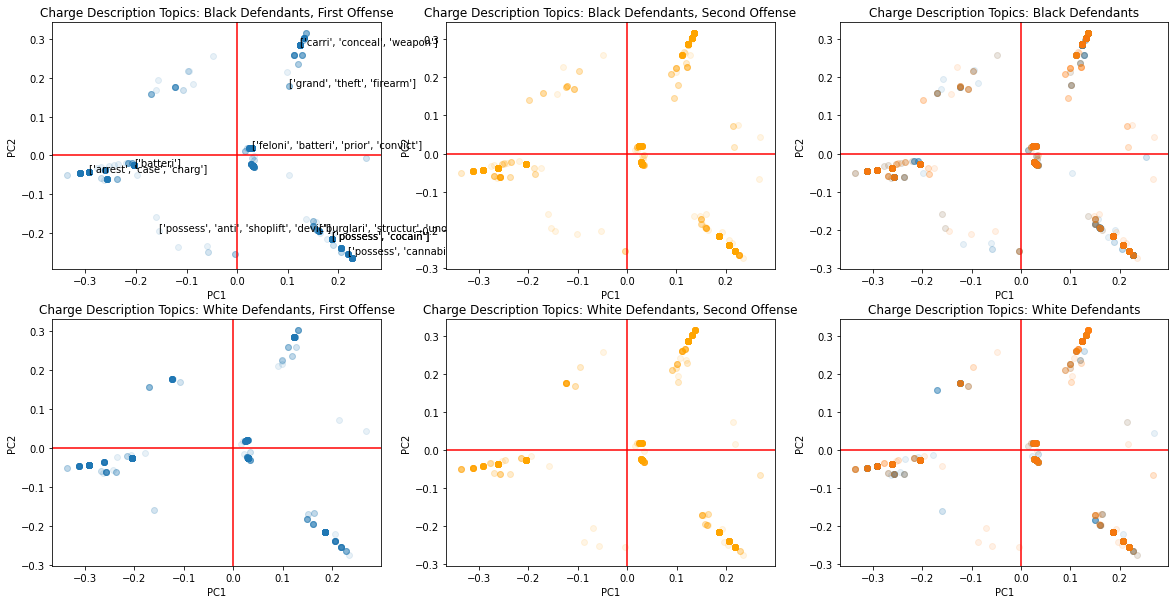

In [488]:
bf_xs = b_first_pcs['PC1'].tolist()
bf_ys = b_first_pcs['PC2'].tolist()
bf_labels = b_first_pcs['tokenized description'].tolist()

bs_xs = b_second_pcs['PC1'].tolist()
bs_ys = b_second_pcs['PC2'].tolist()

wf_xs = w_first_pcs['PC1'].tolist()
wf_ys = w_first_pcs['PC2'].tolist()

ws_xs = w_second_pcs['PC1'].tolist()
ws_ys = w_second_pcs['PC2'].tolist()

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(20, 10)

ax[0,0].scatter(bf_xs, bf_ys, alpha=0.1)
ax[0,0].axhline(y=0, color='red')
ax[0,0].axvline(x=0, color='red')
for i in range(0, len(bf_xs), 200):
    ax[0,0].annotate(bf_labels[i], (bf_xs[i], bf_ys[i]))
ax[0,0].set_xlabel('PC1')
ax[0,0].set_ylabel('PC2')
ax[0,0].set_title('Charge Description Topics: Black Defendants, First Offense')

ax[0,1].scatter(bs_xs, bs_ys, alpha=0.1, color='orange')
ax[0,1].axhline(y=0, color='red')
ax[0,1].axvline(x=0, color='red')
ax[0,1].set_xlabel('PC1')
ax[0,1].set_ylabel('PC2')
ax[0,1].set_title('Charge Description Topics: Black Defendants, Second Offense')

ax[0,2].scatter(bf_xs, bf_ys, alpha=0.1)
ax[0,2].scatter(bs_xs, bs_ys, alpha=0.1)
ax[0,2].axhline(y=0, color='red')
ax[0,2].axvline(x=0, color='red')
ax[0,2].set_xlabel('PC1')
ax[0,2].set_ylabel('PC2')
ax[0,2].set_title('Charge Description Topics: Black Defendants')


ax[1,0].scatter(wf_xs, wf_ys, alpha=0.1)
ax[1,0].axhline(y=0, color='red')
ax[1,0].axvline(x=0, color='red')
ax[1,0].set_xlabel('PC1')
ax[1,0].set_ylabel('PC2')
ax[1,0].set_title('Charge Description Topics: White Defendants, First Offense')

ax[1,1].scatter(ws_xs, ws_ys, alpha=0.1, color='orange')
ax[1,1].axhline(y=0, color='red')
ax[1,1].axvline(x=0, color='red')
ax[1,1].set_xlabel('PC1')
ax[1,1].set_ylabel('PC2')
ax[1,1].set_title('Charge Description Topics: White Defendants, Second Offense')

ax[1,2].scatter(wf_xs, wf_ys, alpha=0.1)
ax[1,2].scatter(ws_xs, ws_ys, alpha=0.1)
ax[1,2].axhline(y=0, color='red')
ax[1,2].axvline(x=0, color='red')
ax[1,2].set_xlabel('PC1')
ax[1,2].set_ylabel('PC2')
ax[1,2].set_title('Charge Description Topics: White Defendants')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Charge Description Topics: White Defendants')

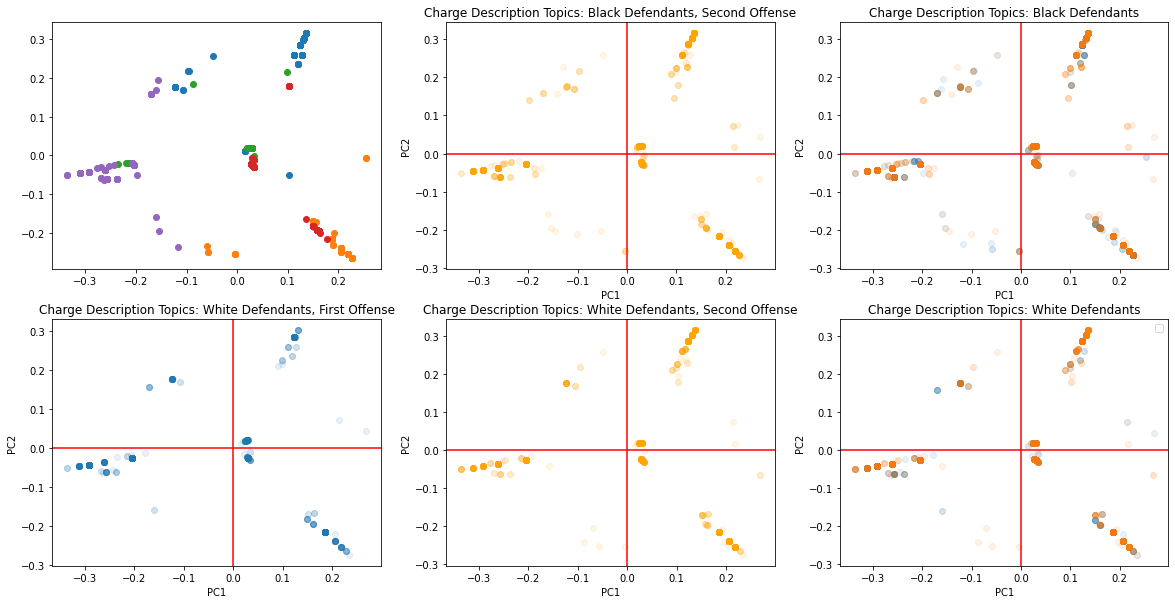

In [671]:
bf_xs = b_first_pcs['PC1'].tolist()
bf_ys = b_first_pcs['PC2'].tolist()
bf_labels = b_first_pcs['tokenized description'].tolist()

bs_xs = b_second_pcs['PC1'].tolist()
bs_ys = b_second_pcs['PC2'].tolist()

wf_xs = w_first_pcs['PC1'].tolist()
wf_ys = w_first_pcs['PC2'].tolist()

ws_xs = w_second_pcs['PC1'].tolist()
ws_ys = w_second_pcs['PC2'].tolist()

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(20, 10)

'''ax[0,0].scatter(bf_xs, bf_ys, c=b_first_pcs['max topic'].tolist(), cmap="Greens")
ax[0,0].axhline(y=0, color='red')
ax[0,0].axvline(x=0, color='red')
for i in range(0, len(bf_xs), 200):
    ax[0,0].annotate(bf_labels[i], (bf_xs[i], bf_ys[i]))
ax[0,0].set_xlabel('PC1')
ax[0,0].set_ylabel('PC2')
ax[0,0].set_title('Charge Description Topics: Black Defendants, First Offense')'''

groups = b_first_pcs.groupby("max topic")
for name, group in groups:
    ax[0,0].plot(group['PC1'], group['PC2'], marker="o", linestyle="", label=name)
plt.legend()

ax[0,1].scatter(bs_xs, bs_ys, alpha=0.1, color='orange')
ax[0,1].axhline(y=0, color='red')
ax[0,1].axvline(x=0, color='red')
ax[0,1].set_xlabel('PC1')
ax[0,1].set_ylabel('PC2')
ax[0,1].set_title('Charge Description Topics: Black Defendants, Second Offense')

ax[0,2].scatter(bf_xs, bf_ys, alpha=0.1)
ax[0,2].scatter(bs_xs, bs_ys, alpha=0.1)
ax[0,2].axhline(y=0, color='red')
ax[0,2].axvline(x=0, color='red')
ax[0,2].set_xlabel('PC1')
ax[0,2].set_ylabel('PC2')
ax[0,2].set_title('Charge Description Topics: Black Defendants')


ax[1,0].scatter(wf_xs, wf_ys, alpha=0.1)
ax[1,0].axhline(y=0, color='red')
ax[1,0].axvline(x=0, color='red')
ax[1,0].set_xlabel('PC1')
ax[1,0].set_ylabel('PC2')
ax[1,0].set_title('Charge Description Topics: White Defendants, First Offense')

ax[1,1].scatter(ws_xs, ws_ys, alpha=0.1, color='orange')
ax[1,1].axhline(y=0, color='red')
ax[1,1].axvline(x=0, color='red')
ax[1,1].set_xlabel('PC1')
ax[1,1].set_ylabel('PC2')
ax[1,1].set_title('Charge Description Topics: White Defendants, Second Offense')

ax[1,2].scatter(wf_xs, wf_ys, alpha=0.1)
ax[1,2].scatter(ws_xs, ws_ys, alpha=0.1)
ax[1,2].axhline(y=0, color='red')
ax[1,2].axvline(x=0, color='red')
ax[1,2].set_xlabel('PC1')
ax[1,2].set_ylabel('PC2')
ax[1,2].set_title('Charge Description Topics: White Defendants')

# coords b pc1: 1995
# coords b pc2: 1995
# coords w pc1: 1001
# coords w pc2: 1001


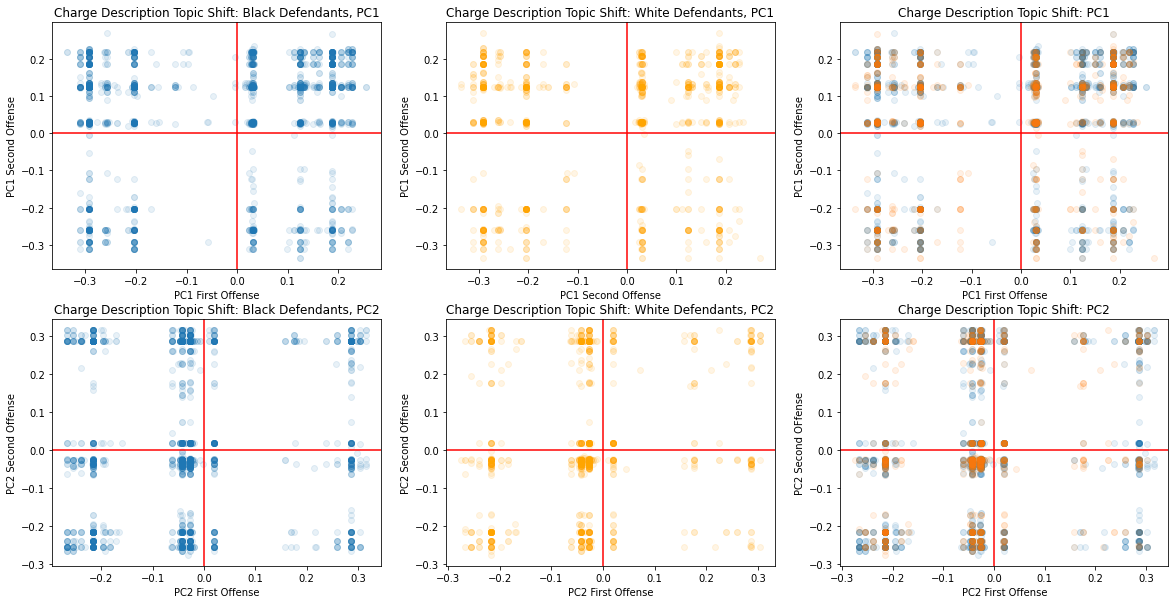

In [449]:
pc1_bf = b_first_pcs['PC1'].tolist()
pc1_bs = b_second_pcs['PC1'].tolist()
print('# coords b pc1:', len(pc1_bf))

pc2_bf = b_first_pcs['PC2'].tolist()
pc2_bs = b_second_pcs['PC2'].tolist()
print('# coords b pc2:', len(pc2_bf))

pc1_wf = w_first_pcs['PC1'].tolist()
pc1_ws = w_second_pcs['PC1'].tolist()
print('# coords w pc1:', len(pc1_wf))

pc2_wf = w_first_pcs['PC2'].tolist()
pc2_ws = w_second_pcs['PC2'].tolist()
print('# coords w pc2:', len(pc2_wf))

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(20, 10)

ax[0,0].scatter(pc1_bf, pc1_bs, alpha=0.1)
ax[0,0].axhline(y=0, color='red')
ax[0,0].axvline(x=0, color='red')
ax[0,0].set_xlabel('PC1 First Offense')
ax[0,0].set_ylabel('PC1 Second Offense')
ax[0,0].set_title('Charge Description Topic Shift: Black Defendants, PC1')

ax[1,0].scatter(pc2_bf, pc2_bs, alpha=0.1)
ax[1,0].axhline(y=0, color='red')
ax[1,0].axvline(x=0, color='red')
ax[1,0].set_xlabel('PC2 First Offense')
ax[1,0].set_ylabel('PC2 Second Offense')
ax[1,0].set_title('Charge Description Topic Shift: Black Defendants, PC2')

ax[0,1].scatter(pc1_wf, pc1_ws, alpha=0.1, color='orange')
ax[0,1].axhline(y=0, color='red')
ax[0,1].axvline(x=0, color='red')
ax[0,1].set_xlabel('PC1 Second Offense')
ax[0,1].set_ylabel('PC1 Second Offense')
ax[0,1].set_title('Charge Description Topic Shift: White Defendants, PC1')

ax[1,1].scatter(pc2_wf, pc2_ws, alpha=0.1, color='orange')
ax[1,1].axhline(y=0, color='red')
ax[1,1].axvline(x=0, color='red')
ax[1,1].set_xlabel('PC2 First Offense')
ax[1,1].set_ylabel('PC2 Second Offense')
ax[1,1].set_title('Charge Description Topic Shift: White Defendants, PC2')


ax[0,2].scatter(pc1_bf, pc1_bs, alpha=0.1)
ax[0,2].scatter(pc1_wf, pc1_ws, alpha=0.1)
ax[0,2].axhline(y=0, color='red')
ax[0,2].axvline(x=0, color='red')
ax[0,2].set_xlabel('PC1 First Offense')
ax[0,2].set_ylabel('PC1 Second Offense')
ax[0,2].set_title('Charge Description Topic Shift: PC1')

ax[1,2].scatter(pc2_bf, pc2_bs, alpha=0.1)
ax[1,2].scatter(pc2_wf, pc2_ws, alpha=0.1)
ax[1,2].axhline(y=0, color='red')
ax[1,2].axvline(x=0, color='red')
ax[1,2].set_xlabel('PC2 First Offense')
ax[1,2].set_ylabel('PC2 Second OFfense')
ax[1,2].set_title('Charge Description Topic Shift: PC2');

In [451]:
b_idx = np.arange(len(b_first_pcs)).tolist()
w_idx = np.arange(len(w_first_pcs)).tolist()
b_sample_idx = random.sample(b_idx, 1000)
w_sample_idx = random.sample(w_idx, 1000)

# coords b pc1: 1000
# coords b pc2: 1000
# coords w pc1: 1000
# coords w pc2: 1000


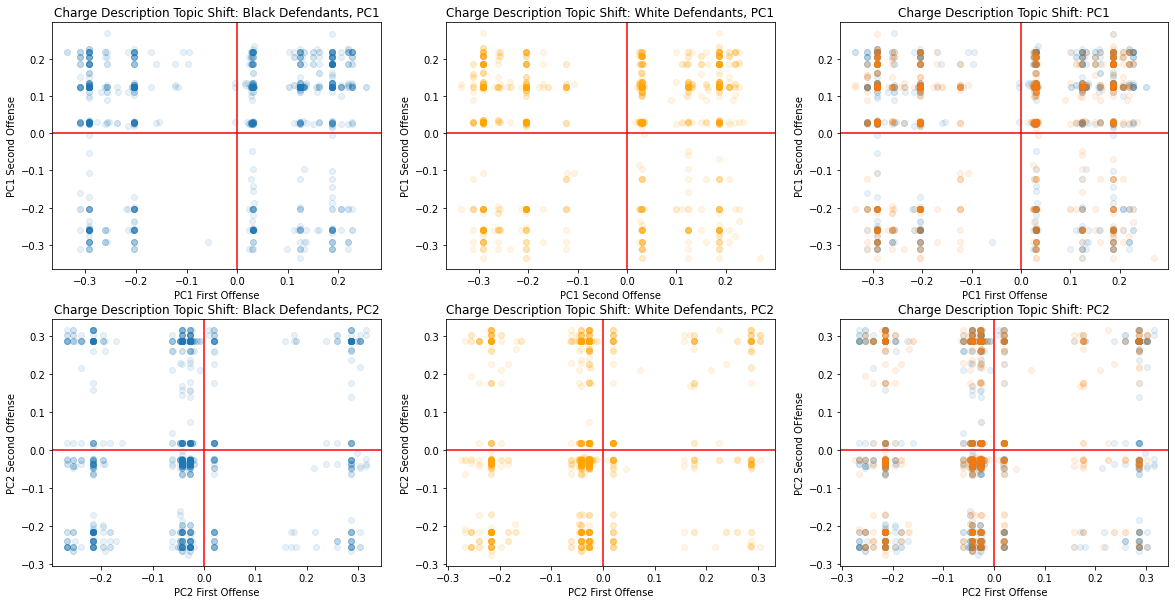

In [452]:
pc1_bf = b_first_pcs['PC1'].tolist()
pc1_bf = [pc1_bf[i] for i in b_sample_idx]
pc1_bs = b_second_pcs['PC1'].tolist()
pc1_bs = [pc1_bs[i] for i in b_sample_idx]
print('# coords b pc1:', len(pc1_bf))

pc2_bf = b_first_pcs['PC2'].tolist()
pc2_bf = [pc2_bf[i] for i in b_sample_idx]
pc2_bs = b_second_pcs['PC2'].tolist()
pc2_bs = [pc2_bs[i] for i in b_sample_idx]
print('# coords b pc2:', len(pc2_bf))

pc1_wf = w_first_pcs['PC1'].tolist()
pc1_wf = [pc1_wf[i] for i in w_sample_idx]
pc1_ws = w_second_pcs['PC1'].tolist()
pc1_ws = [pc1_ws[i] for i in w_sample_idx]
print('# coords w pc1:', len(pc1_wf))

pc2_wf = w_first_pcs['PC2'].tolist()
pc2_wf = [pc2_wf[i] for i in w_sample_idx]
pc2_ws = w_second_pcs['PC2'].tolist()
pc2_ws = [pc2_ws[i] for i in w_sample_idx]
print('# coords w pc2:', len(pc2_wf))

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(20, 10)

ax[0,0].scatter(pc1_bf, pc1_bs, alpha=0.1)
ax[0,0].axhline(y=0, color='red')
ax[0,0].axvline(x=0, color='red')
ax[0,0].set_xlabel('PC1 First Offense')
ax[0,0].set_ylabel('PC1 Second Offense')
ax[0,0].set_title('Charge Description Topic Shift: Black Defendants, PC1')

ax[1,0].scatter(pc2_bf, pc2_bs, alpha=0.1)
ax[1,0].axhline(y=0, color='red')
ax[1,0].axvline(x=0, color='red')
ax[1,0].set_xlabel('PC2 First Offense')
ax[1,0].set_ylabel('PC2 Second Offense')
ax[1,0].set_title('Charge Description Topic Shift: Black Defendants, PC2')

ax[0,1].scatter(pc1_wf, pc1_ws, alpha=0.1, color='orange')
ax[0,1].axhline(y=0, color='red')
ax[0,1].axvline(x=0, color='red')
ax[0,1].set_xlabel('PC1 Second Offense')
ax[0,1].set_ylabel('PC1 Second Offense')
ax[0,1].set_title('Charge Description Topic Shift: White Defendants, PC1')

ax[1,1].scatter(pc2_wf, pc2_ws, alpha=0.1, color='orange')
ax[1,1].axhline(y=0, color='red')
ax[1,1].axvline(x=0, color='red')
ax[1,1].set_xlabel('PC2 First Offense')
ax[1,1].set_ylabel('PC2 Second Offense')
ax[1,1].set_title('Charge Description Topic Shift: White Defendants, PC2')


ax[0,2].scatter(pc1_bf, pc1_bs, alpha=0.1)
ax[0,2].scatter(pc1_wf, pc1_ws, alpha=0.1)
ax[0,2].axhline(y=0, color='red')
ax[0,2].axvline(x=0, color='red')
ax[0,2].set_xlabel('PC1 First Offense')
ax[0,2].set_ylabel('PC1 Second Offense')
ax[0,2].set_title('Charge Description Topic Shift: PC1')

ax[1,2].scatter(pc2_bf, pc2_bs, alpha=0.1)
ax[1,2].scatter(pc2_wf, pc2_ws, alpha=0.1)
ax[1,2].axhline(y=0, color='red')
ax[1,2].axvline(x=0, color='red')
ax[1,2].set_xlabel('PC2 First Offense')
ax[1,2].set_ylabel('PC2 Second OFfense')
ax[1,2].set_title('Charge Description Topic Shift: PC2');

In [ ]:
# find avg PC1 change for groups
# find avg PC2 change for groups

In [540]:
cr_topics_common[cr_topics_common['id']==3]

,id,charge type,name,race,charge description,tokenized description,max topic,PC1,PC2,t1,t2,t3,t4,t5
1,3,C,kevon dixon,African-American,Felony Battery w/Prior Convict,"[feloni, batteri, prior, convict]",3,0.028595,0.019220,0.02265,0.018484,0.925910,0.011355,0.021600
1,3,R,kevon dixon,African-American,Felony Battery (Dom Strang),"[feloni, batteri, domest, strangul]",3,0.028597,0.019219,0.02265,0.018484,0.925911,0.011355,0.021599


In [555]:
c_pcs_df = cr_topics_common[cr_topics_common['charge type']=='C'][['PC1', 'PC2']]
c_pcs = np.array([list(c_pcs_df.PC1), list(c_pcs_df.PC2)]).T
r_pcs_df = cr_topics_common[cr_topics_common['charge type']=='R'][['PC1', 'PC2']]
r_pcs = np.array([list(r_pcs_df.PC1), list(r_pcs_df.PC2)]).T

In [567]:
pc_shift = r_pcs - c_pcs
print(c_pcs[0])
print(r_pcs[0])

[0.02859528 0.01921951]
[0.02859727 0.01921932]


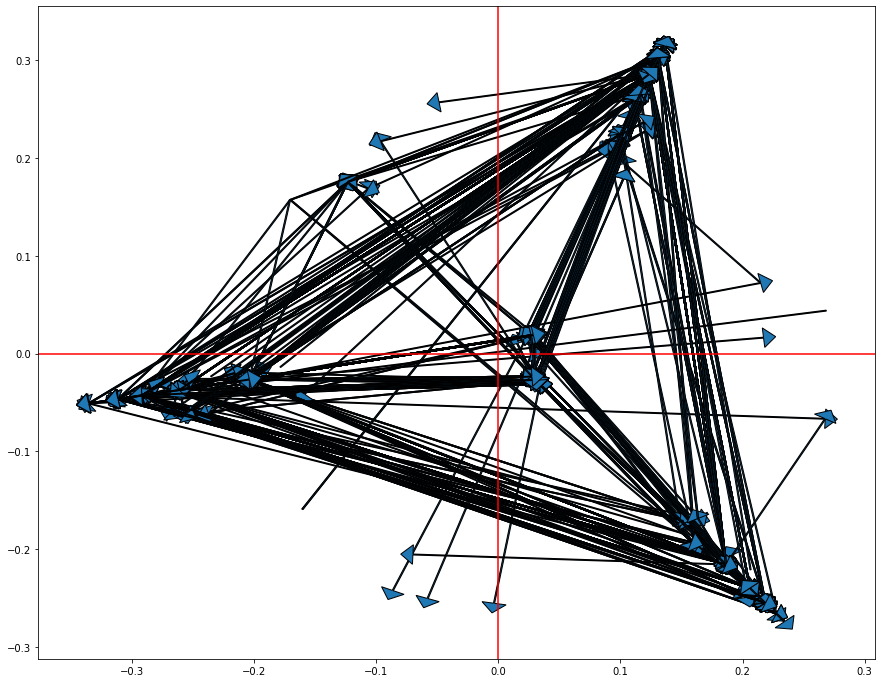

In [643]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 12)
for i in range(pc_shift.shape[0]):
    x = c_pcs[i][0]
    y = c_pcs[i][1]
    dx = pc_shift[i][0]
    dy = pc_shift[i][1]
    ax.arrow(x, y, dx, dy, head_width=0.02, head_length=0.01)

plt.axhline(y=0, color='red')
plt.axvline(x=0, color='red')

In [629]:
b_c_pcs_df = cr_topics_common[(cr_topics_common['charge type']=='C') & (cr_topics_common['race']=='African-American')][['PC1', 'PC2']]
b_c_pcs = np.array([list(b_c_pcs_df.PC1), list(b_c_pcs_df.PC2)]).T
b_r_pcs_df = cr_topics_common[(cr_topics_common['charge type']=='R') & (cr_topics_common['race']=='African-American')][['PC1', 'PC2']]
b_r_pcs = np.array([list(b_r_pcs_df.PC1), list(b_r_pcs_df.PC2)]).T

In [630]:
b_pc_shift = b_r_pcs - b_c_pcs

274


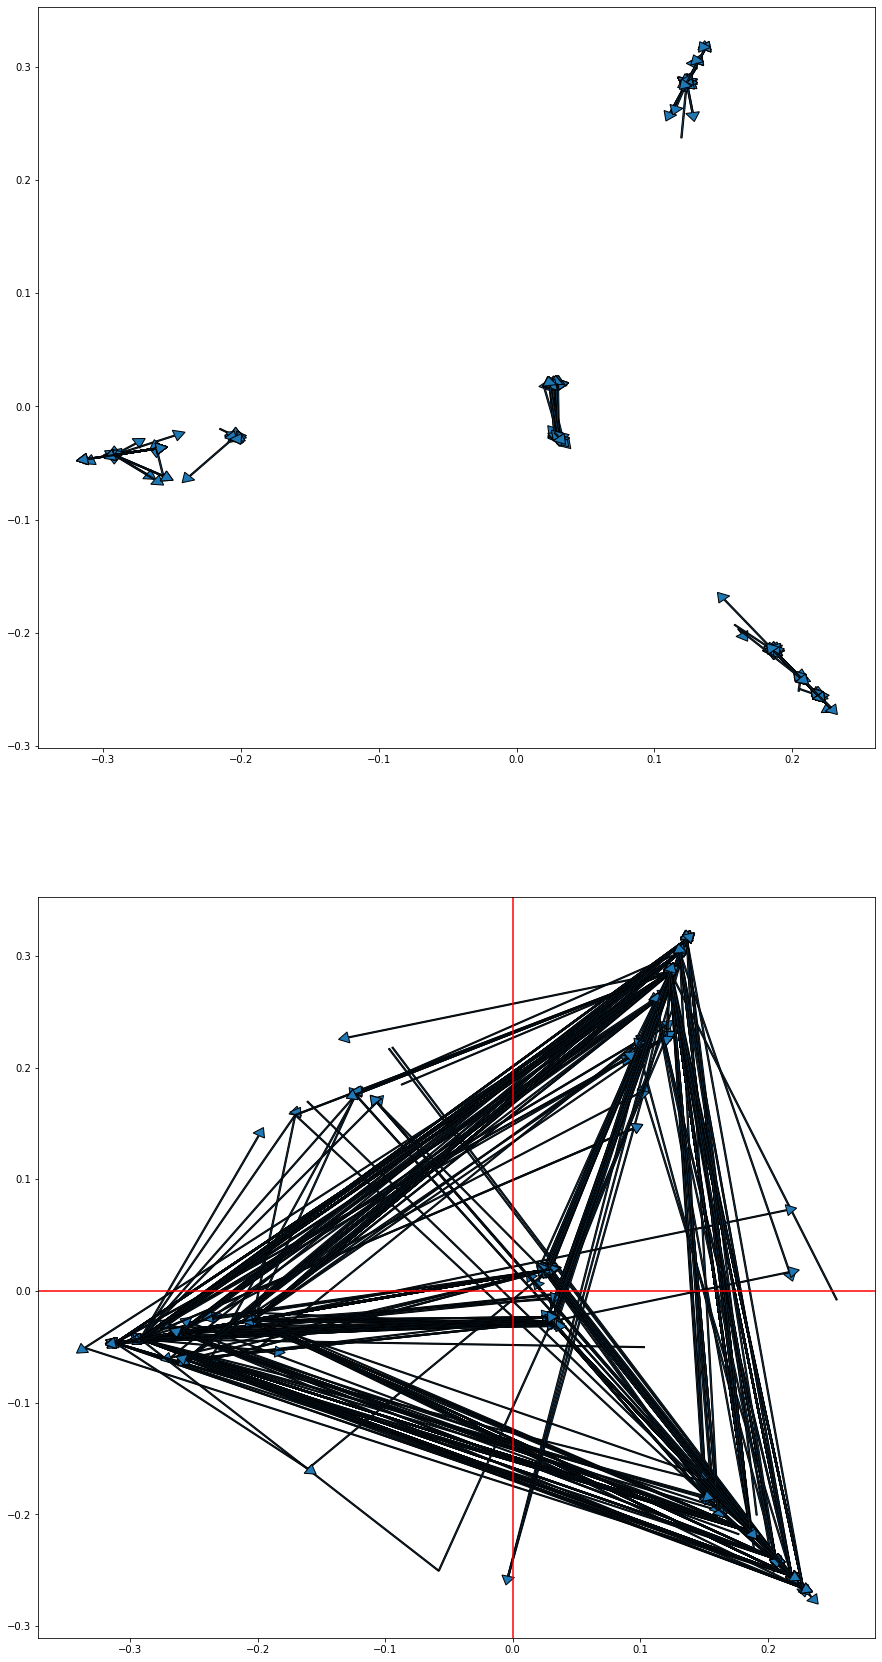

In [660]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(15, 30)
ct = 0
sm_movement = 0
lg_movement = 0
for i in range(0, 1000):
    x = b_c_pcs[i][0]
    y = b_c_pcs[i][1]
    dx = b_pc_shift[i][0]
    dy = b_pc_shift[i][1]
    if ((x + dx) > 0 and (x + dx) < 0.1):
        if ((y + dy) > -0.1 and (y + dy) < 0.1):
            ct += 1
    if (abs(dx) < 0.05) and (abs(dy) < 0.05):
        ax[0].arrow(x, y, dx, dy, head_width=0.01, head_length=0.008)
        sm_movement += 1
    else:
        ax[1].arrow(x, y, dx, dy, head_width=0.01, head_length=0.008)
        lg_movement += 1
        
plt.axhline(y=0, color='red')
plt.axvline(x=0, color='red')
print(sm_movement)

In [634]:
w_c_pcs_df = cr_topics_common[(cr_topics_common['charge type']=='C') & (cr_topics_common['race']=='Caucasian')][['PC1', 'PC2']]
w_c_pcs = np.array([list(w_c_pcs_df.PC1), list(w_c_pcs_df.PC2)]).T
w_r_pcs_df = cr_topics_common[(cr_topics_common['charge type']=='R') & (cr_topics_common['race']=='Caucasian')][['PC1', 'PC2']]
w_r_pcs = np.array([list(w_r_pcs_df.PC1), list(w_r_pcs_df.PC2)]).T

In [641]:
w_pc_shift = w_r_pcs - w_c_pcs
print(w_c_pcs[0])
print(w_r_pcs[0])
np.mean(pc_shift)

[ 0.20609694 -0.23973161]
[ 0.21874706 -0.25511976]


0.07329646453051156

265


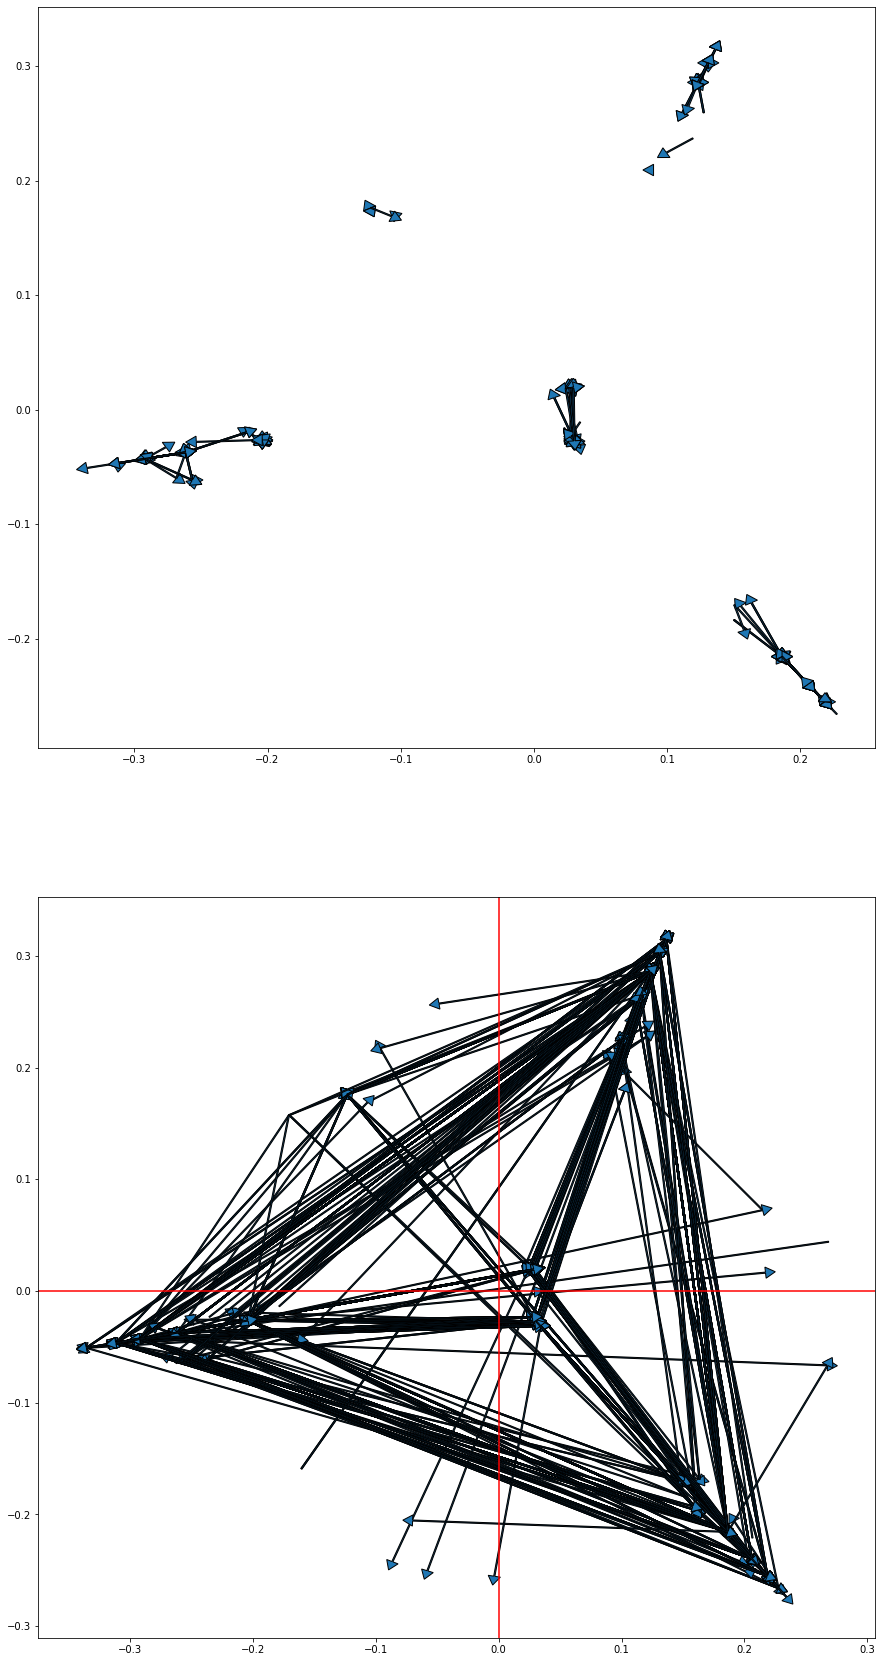

In [662]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(15, 30)
ct = 0
w_sm_movement = 0
w_lg_movement = 0
for i in range(0, w_pc_shift.shape[0]):
    x = w_c_pcs[i][0]
    y = w_c_pcs[i][1]
    dx = w_pc_shift[i][0]
    dy = w_pc_shift[i][1]
    if ((x + dx) > 0 and (x + dx) < 0.1):
        if ((y + dy) > -0.1 and (y + dy) < 0.1):
            ct += 1
    if (abs(dx) < 0.05) and (abs(dy) < 0.05):
        ax[0].arrow(x, y, dx, dy, head_width=0.01, head_length=0.008)
        w_sm_movement += 1
    else:
        ax[1].arrow(x, y, dx, dy, head_width=0.01, head_length=0.008)
        w_lg_movement += 1
        
plt.axhline(y=0, color='red')
plt.axvline(x=0, color='red')
print(w_sm_movement)